In [7]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
from scipy.stats import spearmanr, linregress
import matplotlib.pyplot as plt
import EpiClockNBL.src.util as pc_util
pc_consts = pc_util.consts
import EpiClockNBL.Select_fCpGs.util as local_util
import EpiClockNBL.src.maxima as maxima

In [9]:
# Output directories

proj_dir = os.path.join(pc_consts['official_indir_test'], 'TARGET')

print(pc_consts['official_indir_test'])

figure_outdir = 'figures'
output_dir = 'outputs'
outfile_dir = os.path.join(output_dir, 'outfiles')
outdir = proj_dir

os.makedirs(figure_outdir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(outfile_dir, exist_ok=True)
os.makedirs(outdir, exist_ok=True)

/Users/grahamgumbert/Library/CloudStorage/Box-Box/PROJECT 06023: MolClocks/Neuroblastoma_Paper/Datasets_test


In [11]:
###############################
##### IMPORT/PROCESS DATA #####
###############################

# Import beta values
beta_values_unbiased_sites = pd.read_table(
    os.path.join(proj_dir, 'beta_values_unbiased_sites.txt'),
    index_col=0
)
beta_values_unbiased_sites = beta_values_unbiased_sites.rename(columns=pc_util.getSampleID)

balanced_CpGs = beta_values_unbiased_sites.index.values
print(f'Starting with {balanced_CpGs.shape[0]} balanced sites')

Starting with 42473 balanced sites


In [13]:
# Import clinical table
clinical = pd.read_table(
#     index_col='submitter_id',    # not sure why this won't work -- might be because of quotes - output of R write.table
    os.path.join(proj_dir, 'cohort1.clinical.tsv')
)
clinical = clinical.set_index('submitter_id')

sampleIDs = beta_values_unbiased_sites.columns.values
patient_to_sample_IDs = pd.Series(data=sampleIDs, index=[pc_util.sampleToPatientID(x) for x in sampleIDs]).rename('sampleID')
clinical = clinical.merge(patient_to_sample_IDs, left_index=True, right_index=True, how='left')

In [14]:
# Remove sites that correlate with patient age

assert np.all((clinical['age_at_diagnosis'] + clinical['days_to_birth']).dropna() == 0)

spear_absCorr_list = []
patientID_list = beta_values_unbiased_sites.columns.map(pc_util.sampleToPatientID)
age_ser = clinical.loc[patientID_list, ['sampleID', 'age_at_diagnosis']].set_index('sampleID').squeeze('columns')
i = 0
for site in beta_values_unbiased_sites.index:
    if i % 10000 == 0:
        print(i)
    i += 1
    spear_absCorr_list.append(
        abs(
            spearmanr(
                pd.concat([beta_values_unbiased_sites.loc[site], age_ser], axis=1).dropna()
            ).correlation
        )
    )

spear_absCorr_ser = pd.Series(index=beta_values_unbiased_sites.index, data=spear_absCorr_list)

0
10000
20000
30000
40000


Text(0.5, 1.0, 'TARGET-NBL\nUnbiased sites (centered mean in tumors)')

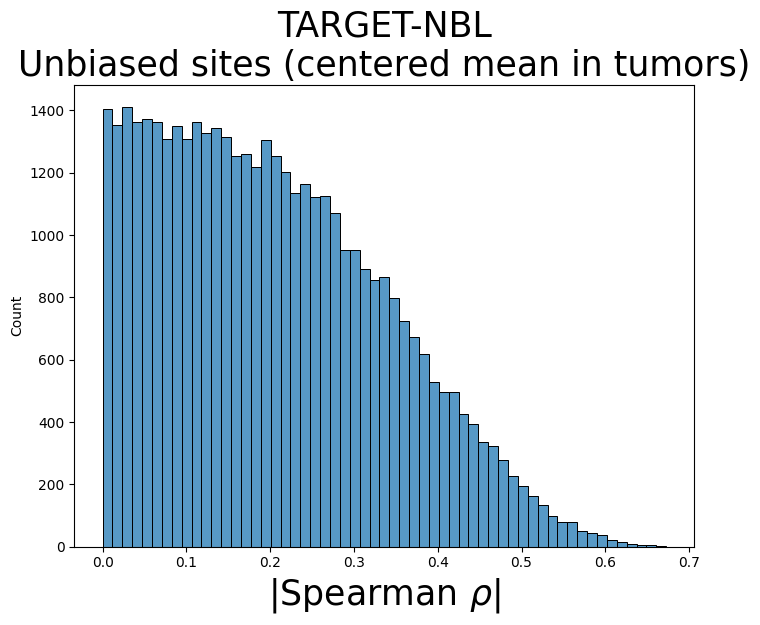

In [15]:
sf = 1

fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(spear_absCorr_ser)

ax.set_xlabel(r'|Spearman $\rho$|', fontsize=pc_consts['labelfontsize']*sf)
ax.set_title('TARGET-NBL\nUnbiased sites (centered mean in tumors)', fontsize=pc_consts['labelfontsize']*sf)

# Need to investigate this in other cancers

### Remove correlating sites

In [16]:
nonCorrelating_sites = spear_absCorr_ser.index[spear_absCorr_ser < 0.2]
beta_values_unbiased_sites = beta_values_unbiased_sites.loc[nonCorrelating_sites]

## Rest of selection process

In [17]:
# Ideally, 1000 Clock sites selected
# We dont want to select more than half the number of unbiased sites (n)
# If n/2 < 1000, only pick n/2 sites
target_n = min(1000, int(balanced_CpGs.shape[0] / 2))
print(f'Picking {target_n} target sites')


########################
##### SELECT SITES #####
########################

# Fill missing values with mean of that site across tumors
km_beta_values = beta_values_unbiased_sites.apply(lambda x:x.fillna(x.mean()), axis=1)

# Determine clustering weights
# See local_util for details
clustering_weights_list = [local_util.clusteringWeights(km_beta_values, random_state=0) for i in range(50)]
clustering_weights_ser = pd.concat(clustering_weights_list, axis=1).mean(axis=1)

# Calculate inter-tumor stdevs of sites
# Make array of unbiased sites that are not in the lowest 25%
balanced_beta_stdevs = beta_values_unbiased_sites.std(axis=1).dropna()
balanced_notStuck = balanced_beta_stdevs.index[balanced_beta_stdevs > np.quantile(balanced_beta_stdevs, 0.25)].values

# Only consider sites in balanced_notStuck
# Sort sites by clustering weights and select 1000 (or fewer) sites with the lowest weight
most_random_sites_nonIterNotStuck = clustering_weights_ser.loc[balanced_notStuck].sort_values().index[:target_n].values

# Calculate c_beta using Clock sites
c_beta = 1 - beta_values_unbiased_sites.loc[most_random_sites_nonIterNotStuck].std(axis=0)
n_samps = 36

########################
###### SAVE FILES ######
########################

# Reset variable name
Clock_CpGs = most_random_sites_nonIterNotStuck

## Save Clock CpG list
Clock_CpGs_filepath = os.path.join(output_dir, f'NBL_Clock_CpGs.txt')

# Save Clock sites, don't overwrite existing file
if os.path.exists(Clock_CpGs_filepath):
    existing_set = np.loadtxt(Clock_CpGs_filepath, dtype=str)
    assert np.all(np.sort(Clock_CpGs) == np.sort(existing_set))
    print('Current output matches existing file.')
else:
    np.savetxt(Clock_CpGs_filepath, Clock_CpGs, fmt='%s')

## Save c_beta values of final tumors
c_beta_final_samples = c_beta
c_beta_filepath = os.path.join(output_dir, f'NBL.c_beta.txt')

# Save c_beta values, don't overwrite existing file
if os.path.exists(c_beta_filepath):
    existing_c_beta = pd.read_table(c_beta_filepath, index_col=0, header=None).squeeze("columns")
    assert (c_beta_final_samples - existing_c_beta < 1e-6).all()
    print('Current output matches existing file.')
else:
    c_beta_final_samples.to_csv(c_beta_filepath, sep='\t', header=False)

# Save beta values of Clock sites
outfile_path = os.path.join(outdir, f'NBL.methyl.antiNonIterClustNotStuck_sites.tsv')
beta_values_unbiased_sites.loc[Clock_CpGs].to_csv(outfile_path, sep='\t')

Picking 1000 target sites


## Examine K-Means/PCA

In [18]:
from sklearn.cluster import KMeans

km_beta_values = beta_values_unbiased_sites.apply(lambda x:x.fillna(x.mean()), axis=1)
km = KMeans(n_clusters=4, random_state=None).fit(km_beta_values.T)

In [19]:
from sklearn.decomposition import PCA

In [20]:
tumors_transformed = PCA(2).fit_transform(km_beta_values.T)

<Axes: xlabel='x', ylabel='y'>

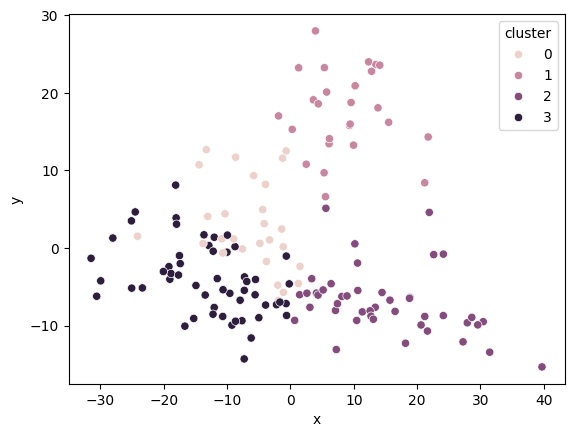

In [21]:
plot_data = pd.concat([pd.DataFrame(tumors_transformed, columns=['x', 'y']), pd.Series(km.labels_, name='cluster')], axis=1)
sns.scatterplot(data=plot_data, x='x', y='y', hue='cluster')

In [22]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

km_beta_values = beta_values_unbiased_sites.apply(lambda x:x.fillna(x.mean()), axis=1)
km = KMeans(n_clusters=4, random_state=None).fit(km_beta_values.T)

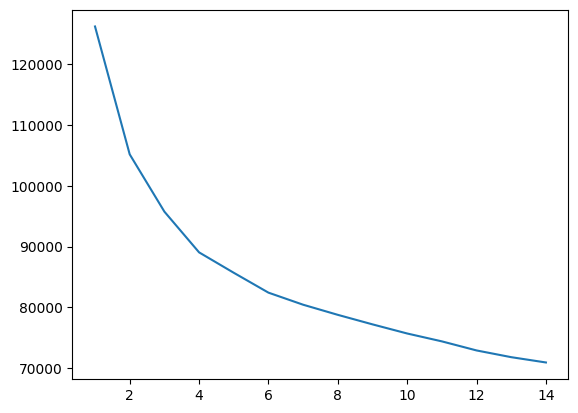

In [23]:
RSS_list = []
choices = list(range(1, 15))
for i in choices:
    inertia_list = [KMeans(n_clusters=i, random_state=None).fit(km_beta_values.T).inertia_ for j in range(20)]
    RSS_list.append(np.mean(inertia_list))

plt.plot(choices, RSS_list)